In [1]:
import os
import time

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("Package is ready.")

Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = ((8/2.54)*2, (6/2.54)*2)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 15})
MARKER_SIZE = 3
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

In [3]:
N_FOLD =5
pred_results = []

In [4]:
manual_ECpH_df = pd.read_excel("../data/SW_Ion/manual_ECnpH.xlsx", index_col="Date")
manual_ECpH_df.index = pd.DatetimeIndex(manual_ECpH_df.index) + pd.Timedelta("16h")
manual_ECpH_df = manual_ECpH_df[["Water pH","3_EC","3_pH","4_EC","4_pH"]]

In [5]:
manual_ECpH_df = manual_ECpH_df.reindex(pd.date_range(manual_ECpH_df.index[0], manual_ECpH_df.index[-1]))

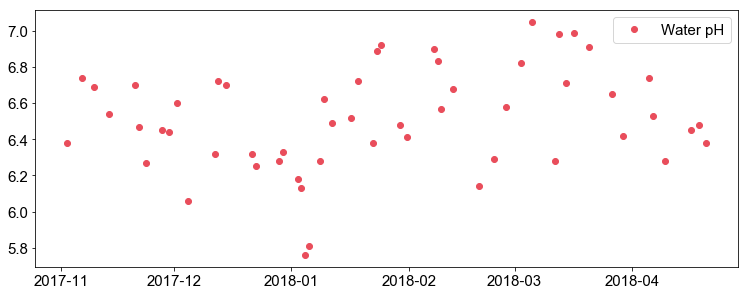

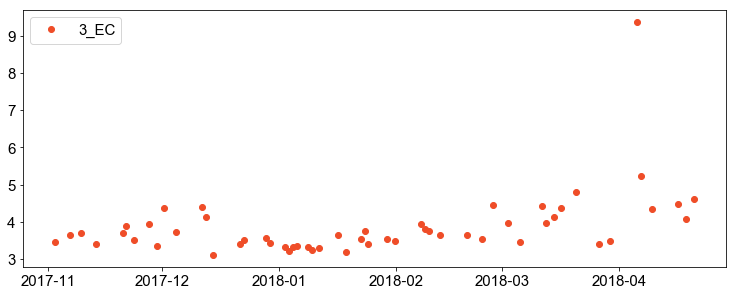

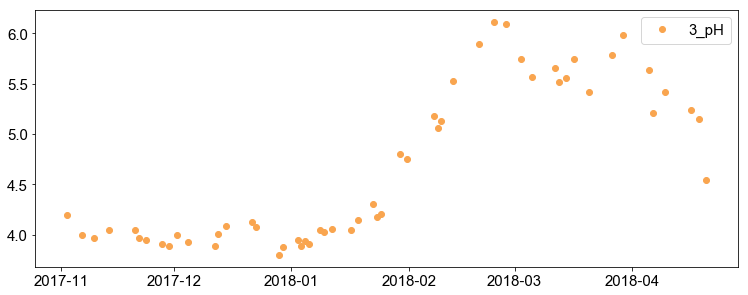

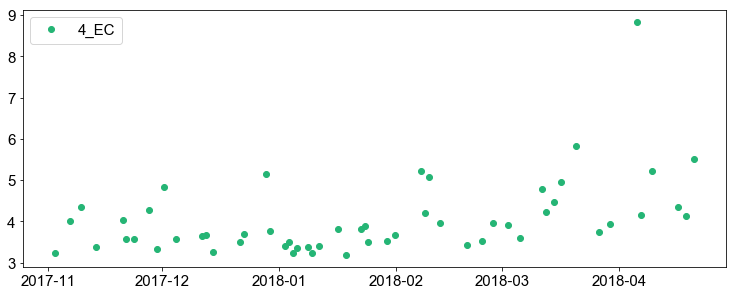

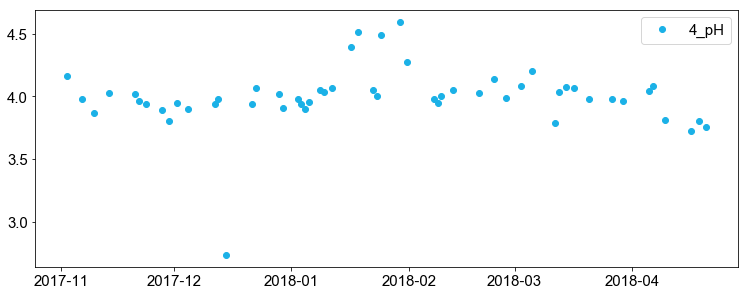

In [6]:
for _ in range(manual_ECpH_df.shape[1]):
    plt.figure(figsize=((8/2.54)*4, (6/2.54)*2))
    line = plt.plot(manual_ECpH_df.index, manual_ECpH_df.iloc[:, _], "o", c=cmap[_], label = manual_ECpH_df.columns[_])
    plt.legend(handles=line)
    plt.show()

#  Greenhouse Environment

In [7]:
env_df = pd.read_csv("./results/open_data.csv", index_col="TIMESTAMP")
env_df.index = pd.DatetimeIndex(env_df.index)
env_df = env_df[["Pyrano_W", "GrnHsTemp(2)", "GrnHsHum(2)", "ECS(4)", "ECD(4)", "RWEC(4)", "MixTnkpH(4)", "RootTemp(2)"]]

In [8]:
env_df = env_df[~(env_df.index < '2017-11-17')]

In [9]:
env_date = pd.date_range(env_df.index[0], env_df.index[-1], freq="10min")

In [10]:
#Dropping outlier
__ = env_df[["Pyrano_W"]].copy()
env_df = env_df[np.abs(env_df-env_df.mean())<=(3*env_df.std())]
env_df.loc["2018-01-21 11:50:00", "RootTemp(2)"] = pd.np.nan
env_df["Pyrano_W"] = __

In [11]:
# env_mean = env_df.rolling(1, win_type='triang').mean()
env_mean = env_df.copy()
# env_mean.index = (env_mean.index).round("1h")#  - pd.Timedelta("10min")
# env_mean = env_mean.groupby(env_mean.index).mean()
env_mean.iloc[0, 5] = 4
env_mean.iloc[0, 6] = 20
env_mean.interpolate("linear", inplace=True)
# env_mean = env_mean[~(env_mean.index < '2017-12-22')]

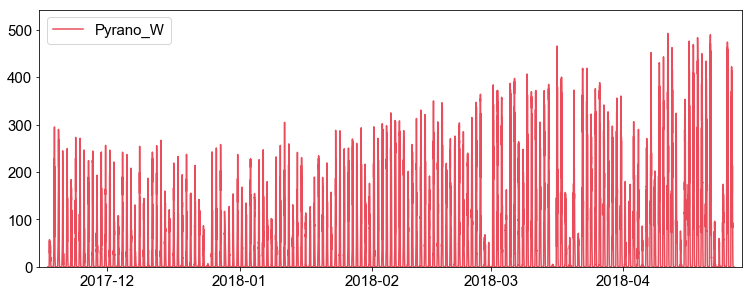

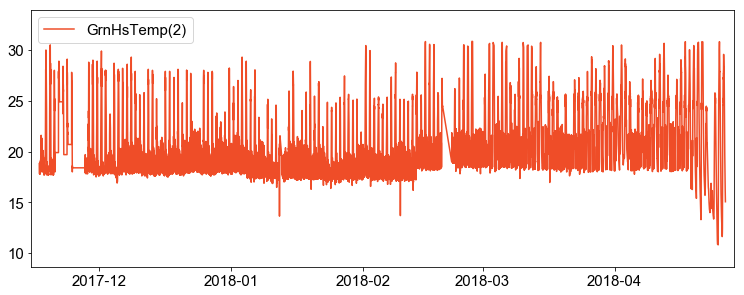

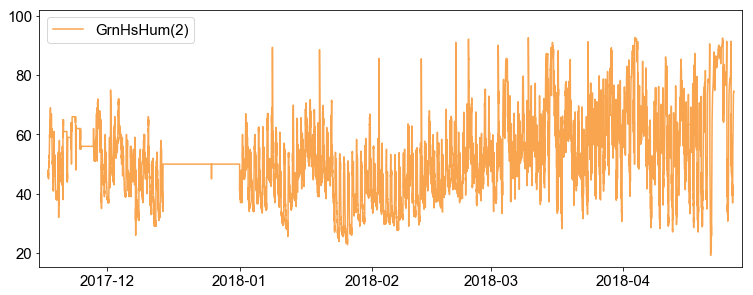

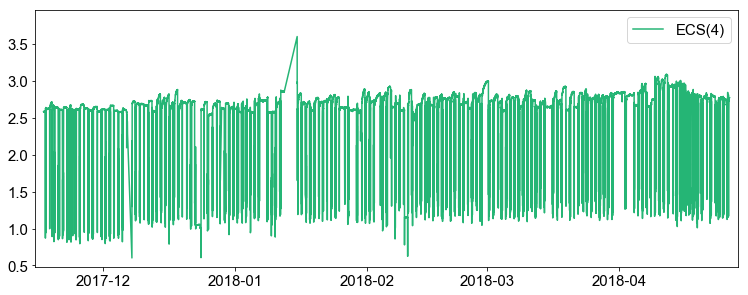

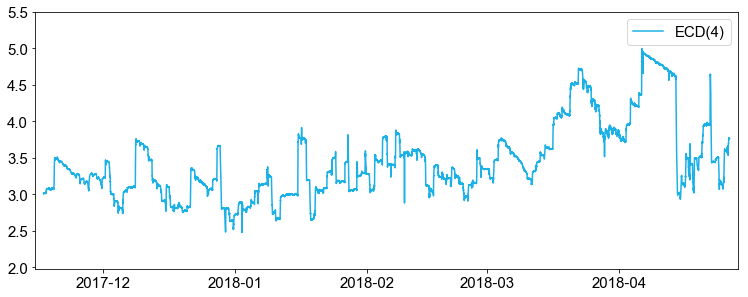

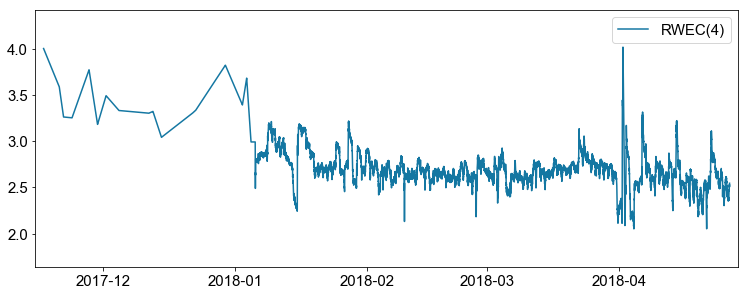

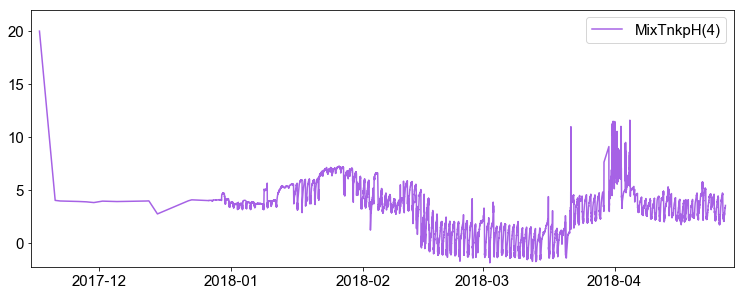

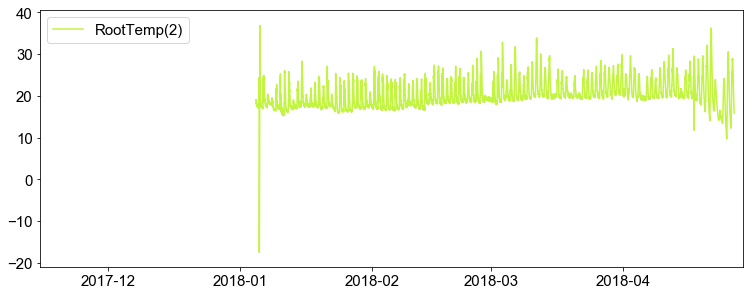

In [12]:
for _ in range(env_df.shape[1]):
    plt.figure(figsize=((8/2.54)*4, (6/2.54)*2))
    line = plt.plot(env_mean.index, env_mean.iloc[:, _], c=cmap[_], label = env_mean.columns[_])
    plt.legend(handles=line)
    plt.axis([env_mean.index[0] - pd.Timedelta('2d'), env_mean.index[-1] + pd.Timedelta('2d'),
              env_mean.iloc[:, _].min() - abs(env_mean.iloc[:, _].min()*0.2), env_mean.iloc[:, _].max()*1.1])
    plt.show()

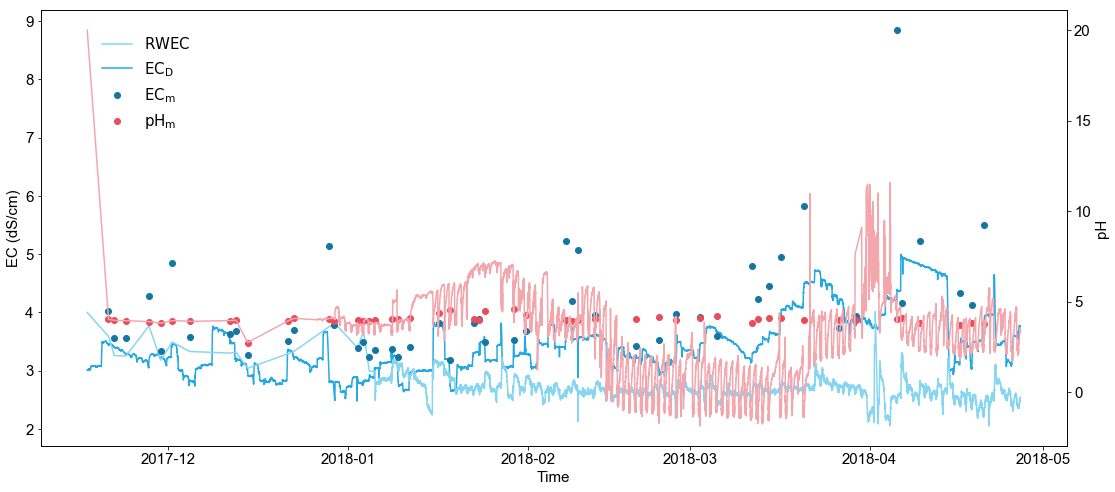

In [13]:
x_date = env_mean.index

fig , ec = plt.subplots(figsize=((8/2.54)*5, (6/2.54)*3))
linear_ecd, = ec.plot(x_date, env_mean["ECD(4)"], "-", c=cmap_m[5], label = "ECd")
linear_ecs, = ec.plot(x_date, env_mean["RWEC(4)"], "-", c=cmap_m[4], label = "ECs")
linear_mec, = ec.plot(x_date, manual_ECpH_df["4_EC"].reindex(x_date), "o", c=cmap[5], label = "EC")
ec.set_xlabel("Time"),
ec.set_ylabel("EC (dS/cm)")
#ec.set_ybound([2.5,5])

ph = ec.twinx()

linear_mph, = ph.plot(x_date, manual_ECpH_df["4_pH"].reindex(x_date), "o", c=cmap[0], label = "pH")
linear_ph, = ph.plot(x_date, env_mean["MixTnkpH(4)"], "-", c=cmap_m[0], label = "pHs")

ph.set_ylabel("pH")

fig.legend(handles=[linear_ecs,linear_ecd, linear_mec, linear_mph], labels = ["$RWEC$", "$EC_D$", "$EC_m$", "$pH_m$"], frameon=False, bbox_to_anchor=(0.18, 0.92))

#plt.axis([x_date[0] - 5, x_date[-1] + 5, min_ - 1, max_ + 15])
#ph.set_ybound([0,12])
fig.tight_layout()
plt.show()

# Prediction Results

In [14]:
for i in range(N_FOLD):
    pred_results.append(pd.read_csv("./results/results_Ion_open_LN_I1h_T168_F" + str(i+1) + ".csv", index_col="date"))
pred_result = pd.concat(pred_results)
pred_result = pred_result.sort_index()

In [15]:
pred_result = pred_result[~pred_result.index.duplicated()]
pred_result.index = pd.DatetimeIndex(pred_result.index)

all_date = pd.date_range(pred_result.index[0], pred_result.index[-1])
pred_result = pred_result.reindex(all_date)

In [16]:
pred_result.to_csv("./results/shuffled_pred_open_label.csv")

In [17]:
ion_label = pd.read_excel("../data/SW_Ion/Ion concentration_meq_20171109-20180426.xlsx", skiprows=1, index_col="date")
ion_label = ion_label.iloc[1:,:].copy()
#ion_label.drop(["N"], axis=1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if "Unnamed:" in columns], axis= 1, inplace=True)
#ion_label.drop([columns for columns in ion_label.columns if ".1" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".2" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".3" in columns], axis= 1, inplace=True)
#ion_label.dropna(inplace=True)
ion_label = ion_label[~(ion_label.index < '2017-11-17')]
ion_label.index = pd.DatetimeIndex(ion_label.index)

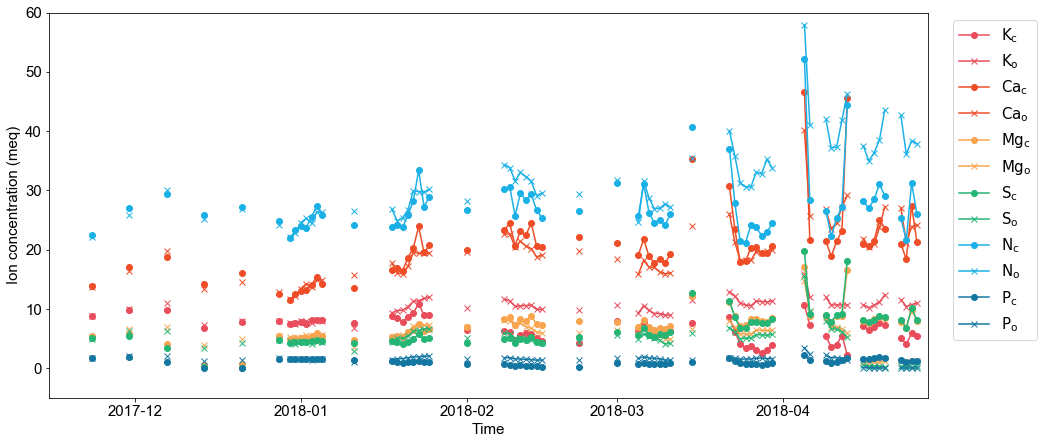

In [18]:
x_date = ion_label.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in range(6):
    linear_closed = plt.plot(x_date, ion_label.iloc[:, _], "o-", markersize = MARKER_SIZE*2, c=cmap[_])
    linear_open = plt.plot(x_date, ion_label.iloc[:, _+6], "x-", markersize = MARKER_SIZE*2, c=cmap[_])

plt.legend(["$K_c$", "$K_o$", "$Ca_c$", "$Ca_o$", "$Mg_c$", "$Mg_o$", "$S_c$", "$S_o$", "$N_c$", "$N_o$", "$P_c$", "$P_o$"], bbox_to_anchor=(1.02, 1))
plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
plt.axis([x_date[0] - pd.Timedelta('2d'), x_date[-1] + pd.Timedelta('2d'), -5, 60])
plt.show()

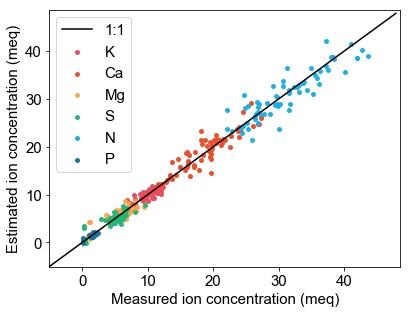

In [19]:
min_ = min(pred_result.min())
max_ = max(pred_result.max())
x_linear = np.arange(min_ - 5, max_ + 5)
y_linear = x_linear


linear = plt.plot(x_linear, y_linear, "k-")
for _ in range(6):
    scatter = plt.scatter(pred_result.iloc[:, _], pred_result.iloc[:, _+6], s=MARKER_SIZE*5, c=cmap[_])
    

plt.legend(["1:1", "K", "Ca", "Mg", "S", "N", "P"])
plt.xlabel("Measured ion concentration (meq)")
plt.ylabel("Estimated ion concentration (meq)")
plt.axis([min_ - 5, max_ + 5, min_ - 5, max_ + 5])
plt.show()

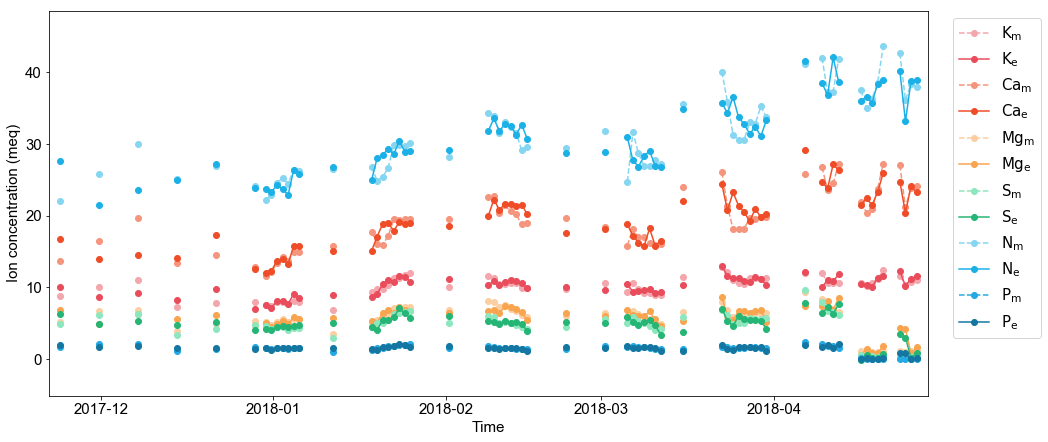

In [20]:
x_date = pred_result.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in range(6):
    linear = plt.plot(x_date, pred_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_])
    linear_pred = plt.plot(x_date, pred_result.iloc[:, _+6], "o-", markersize = MARKER_SIZE*2, c=cmap[_])

plt.legend(["$K_m$", "$K_e$", "$Ca_m$", "$Ca_e$", "$Mg_m$", "$Mg_e$", "$S_m$", "$S_e$", "$N_m$", "$N_e$", "$P_m$", "$P_e$"], bbox_to_anchor=(1.02, 1))
plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
plt.axis([x_date[0] - pd.Timedelta('2d'), x_date[-1] + pd.Timedelta('2d'), min_ - 5, max_ + 5])
plt.show()

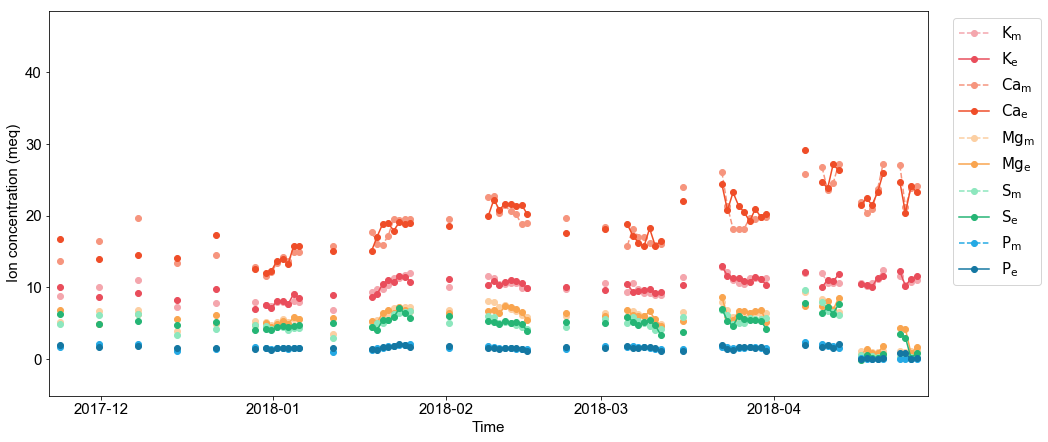

In [21]:
x_date = pred_result.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in [0,1,2,3,5]:
    #scatter_gt = plt.scatter(x_date, pred_result.iloc[:, _], s=MARKER_SIZE, c=cmap[_])
    #scatter_pred = plt.scatter(x_date, pred_result.iloc[:, _+6], s=MARKER_SIZE, c=cmap[_])
    linear = plt.plot(x_date, pred_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_])
    linear_pred = plt.plot(x_date, pred_result.iloc[:, _+6], "o-", markersize = MARKER_SIZE*2, c=cmap[_])

plt.legend(["$K_m$", "$K_e$", "$Ca_m$", "$Ca_e$", "$Mg_m$", "$Mg_e$", "$S_m$", "$S_e$", "$P_m$", "$P_e$"], bbox_to_anchor=(1.02, 1))
plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
plt.axis([x_date[0] - pd.Timedelta('2d'), x_date[-1] + pd.Timedelta('2d'), min_ - 5, max_ + 5])
plt.show()

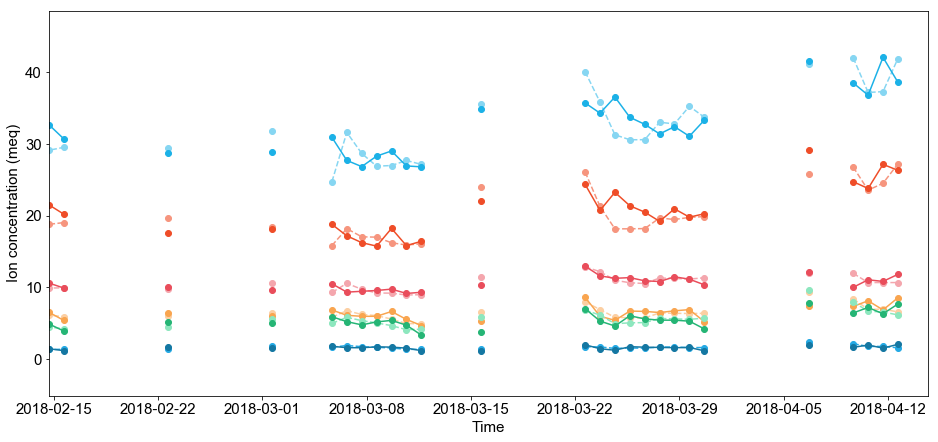

In [22]:
x_date = pred_result.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in range(6):
    #scatter_gt = plt.scatter(x_date, pred_result.iloc[:, _], s=MARKER_SIZE, c=cmap[_])
    #scatter_pred = plt.scatter(x_date, pred_result.iloc[:, _+6], s=MARKER_SIZE, c=cmap[_])
    linear = plt.plot(x_date, pred_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_])
    linear_pred = plt.plot(x_date, pred_result.iloc[:, _+6], "o-", markersize = MARKER_SIZE*2, c=cmap[_])

plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
plt.axis([x_date[85] - pd.Timedelta('2d'), x_date[-15] + pd.Timedelta('2d'), min_ - 5, max_ + 5])
plt.show()

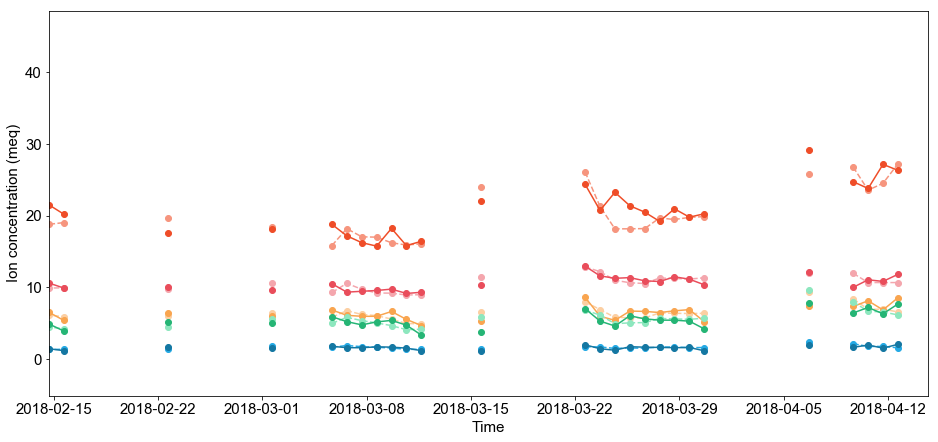

In [23]:
x_date = pred_result.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in [0,1,2,3,5]:
    #scatter_gt = plt.scatter(x_date, pred_result.iloc[:, _], s=MARKER_SIZE, c=cmap[_])
    #scatter_pred = plt.scatter(x_date, pred_result.iloc[:, _+6], s=MARKER_SIZE, c=cmap[_])
    linear = plt.plot(x_date, pred_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_])
    linear_pred = plt.plot(x_date, pred_result.iloc[:, _+6], "o-", markersize = MARKER_SIZE*2, c=cmap[_])

plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
plt.axis([x_date[85] - pd.Timedelta('2d'), x_date[-15] + pd.Timedelta('2d'), min_ - 5, max_ + 5])
plt.show()

In [24]:
interpol_result = pd.read_csv("./results/results_Ion_open_interpolate.csv", index_col="date")
interpol_result = interpol_result.sort_index()

In [25]:
interpol_result = interpol_result[~interpol_result.index.duplicated()]
interpol_result.index = pd.DatetimeIndex(interpol_result.index)
interpol_result.index = interpol_result.index + pd.Timedelta("16h")
#interpol_result.drop(pred_result.dropna().index, inplace=True)
all_date = pd.date_range(pred_result.index[0], pred_result.index[-1])
interpol_result = interpol_result.reindex(all_date)

In [26]:
ground_result = pred_result.iloc[:,:6].copy()
ground_result.columns = ["K", "Ca", "Mg", "S", "N", "P"]
ground_result.index = pd.DatetimeIndex(ground_result.index)
ground_result.fillna(interpol_result, inplace=True)

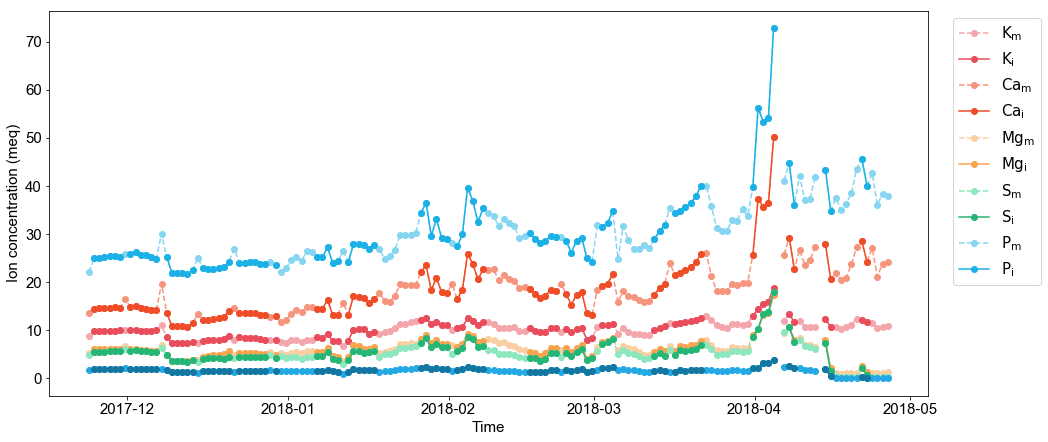

In [27]:
x_date = interpol_result.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in range(6):
    linear_m = plt.plot(x_date, ground_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_])
    linear = plt.plot(x_date, interpol_result.iloc[:, _], "o-", markersize = MARKER_SIZE*2, c=cmap[_], label = interpol_result.columns[_])


plt.legend(["$K_m$", "$K_i$", "$Ca_m$", "$Ca_i$", "$Mg_m$", "$Mg_i$", "$S_m$", "$S_i$", "$P_m$", "$P_i$"], bbox_to_anchor=(1.02, 1))
plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
#plt.axis([x_date[0] - 5, x_date[-1] + 5, min_ - 400, max_ + 1200])
plt.show()

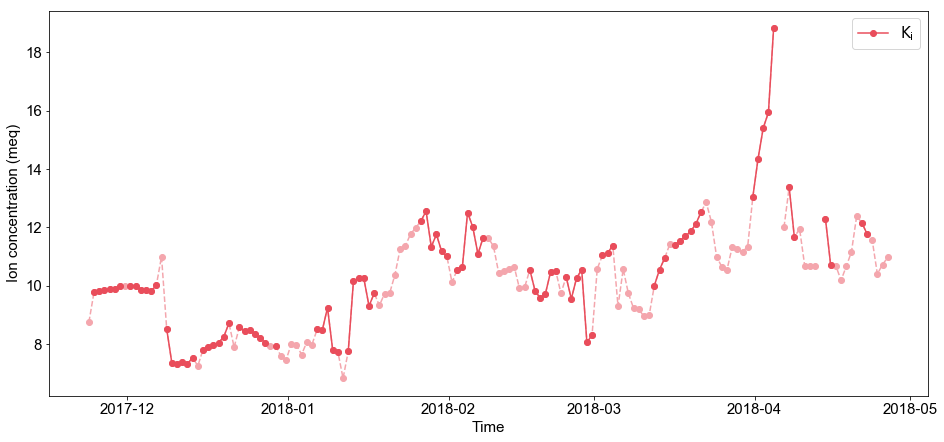

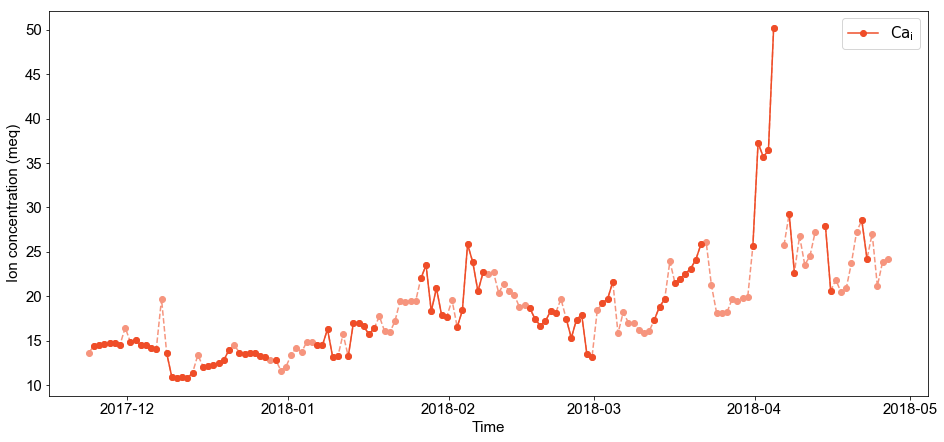

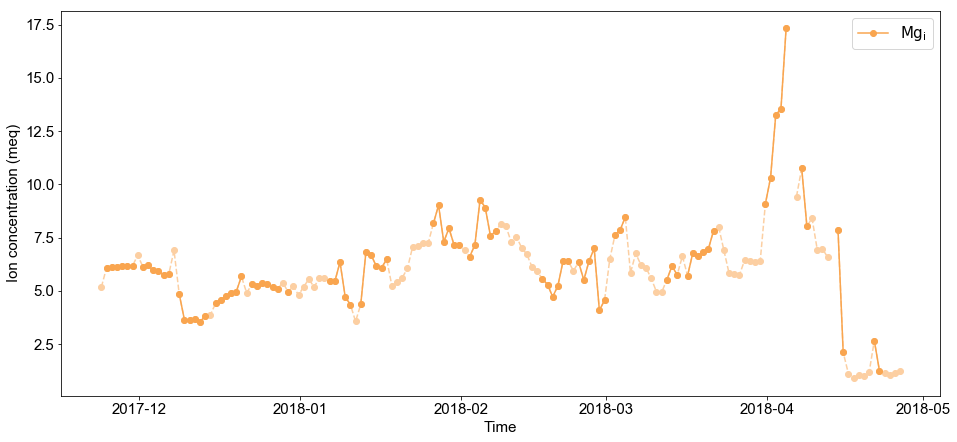

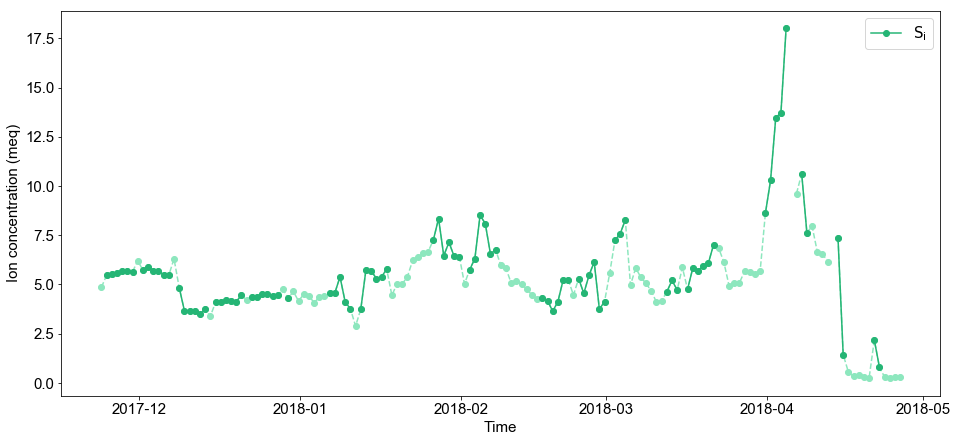

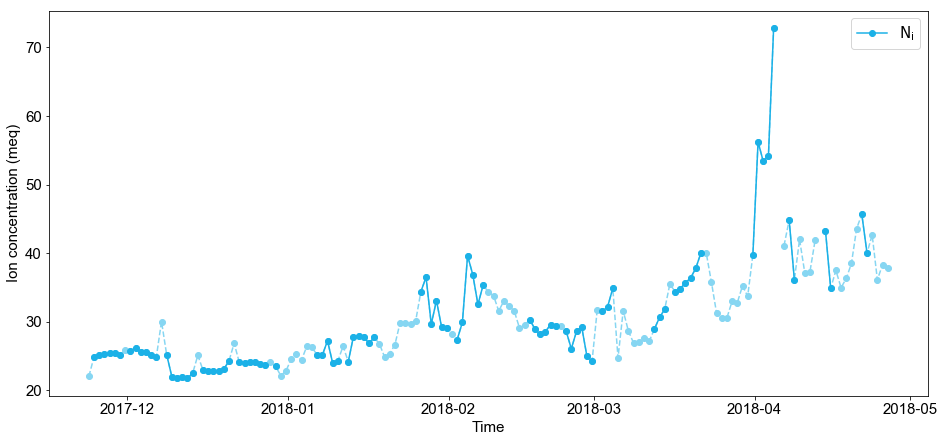

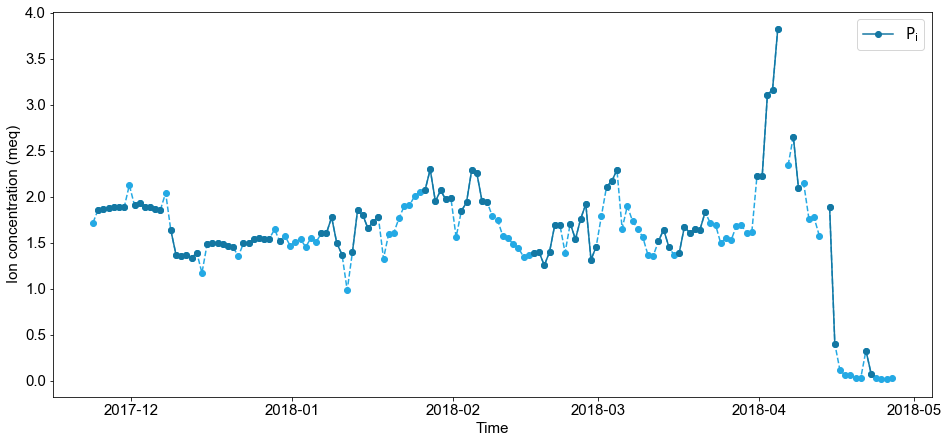

In [28]:
x_date = interpol_result.index


for _ in range(6):
    plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
    linear_m = plt.plot(x_date, ground_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_], label = "$%s_m$" % ground_result.columns[_])
    linear = plt.plot(x_date, interpol_result.iloc[:, _], "o-", markersize = MARKER_SIZE*2, c=cmap[_], label = "$%s_i$" % interpol_result.columns[_])

    plt.legend(handles = linear)
    plt.xlabel("Time")
    plt.ylabel("Ion concentration (meq)")
#plt.axis([x_date[0] - 5, x_date[-1] + 5, min_ - 400, max_ + 1200])
plt.show()

In [29]:
all_meq_interpol = pd.DataFrame(interpol_result.iloc[:,:].sum(axis=1, skipna=False), columns=["All ion"])
all_meq_ground = pd.DataFrame(ground_result.iloc[:,:].sum(axis=1, skipna=False), columns=["All ion"])

In [30]:
env_6h = env_df
#env_6h.index = (env_6h.index).round("1h")#  - pd.Timedelta("10min")
env_6h = env_6h.groupby(env_6h.index).mean()
env_6h.interpolate(inplace=True)
env_6h = env_6h.iloc[12:,:].copy()

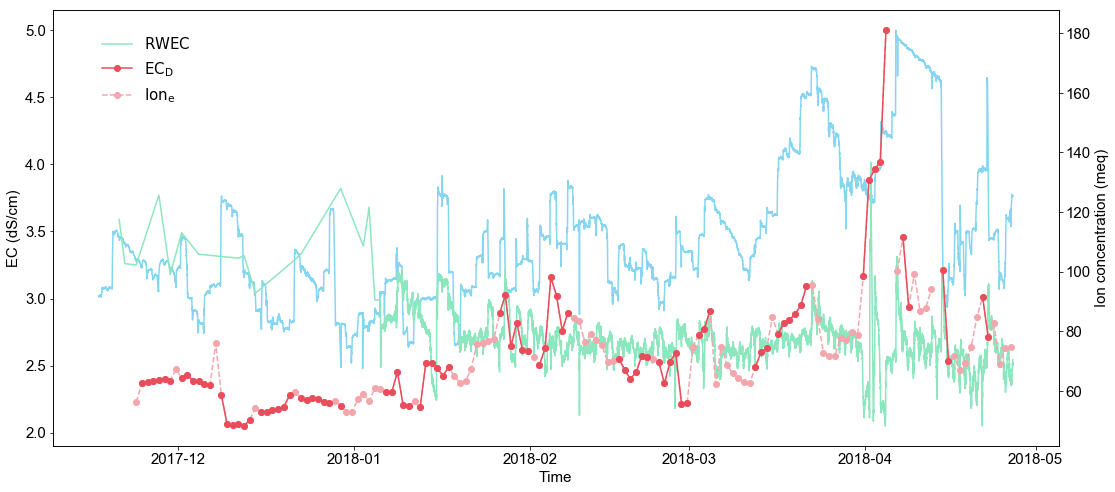

In [31]:
# x_date = interpol_result.index

fig , ec = plt.subplots(figsize=((8/2.54)*5, (6/2.54)*3))
linear_ecd, = ec.plot(env_6h.index, env_6h["ECD(4)"], "-", c=cmap_m[4], label = "EC")
linear_ecs, = ec.plot(env_6h.index, env_6h["RWEC(4)"], "-", c=cmap_m[3], label = "EC")
ec.set_xlabel("Time"),
ec.set_ylabel("EC (dS/cm)")
#ec.set_ybound([2,4])

ion = ec.twinx()
linear_m, = ion.plot(x_date, all_meq_ground.iloc[:, 0], "o--", markersize = MARKER_SIZE*2, c=cmap_m[0], label = "Ion_m")
linear, = ion.plot(x_date, all_meq_interpol.iloc[:, 0], "o-", markersize = MARKER_SIZE*2, c=cmap[0], label = "Ion_p")
ion.set_ylabel("Ion concentration (meq)")

fig.legend(handles=[linear_ecs,linear,linear_m], labels = ["$RWEC$", "$EC_D$", "$Ion_e$", "$Ion_m$"], frameon=False, bbox_to_anchor=(0.18, 0.92))

#plt.axis([x_date[0] - 5, x_date[-1] + 5, min_ - 1, max_ + 15])
fig.tight_layout()
plt.show()

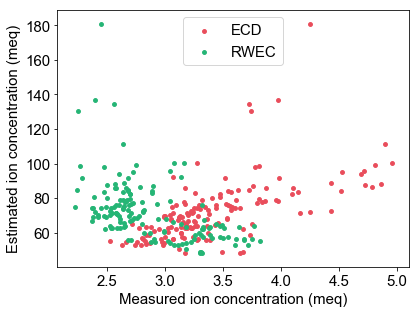

In [32]:
min_ = min(pred_result.min())
max_ = max(pred_result.max())
x_linear = np.arange(min_ - 5, max_ + 5)
y_linear = x_linear


#linear = plt.plot(x_linear, y_linear, "k-")
scatter = plt.scatter(env_6h.loc[all_meq_ground.index, "ECD(4)"], all_meq_ground.iloc[:, 0], s=MARKER_SIZE*5, c=cmap[0])
scatter = plt.scatter(env_6h.loc[all_meq_ground.index, "RWEC(4)"], all_meq_ground.iloc[:, 0], s=MARKER_SIZE*5, c=cmap[3])

plt.legend(["ECD", "RWEC"])
plt.xlabel("Measured ion concentration (meq)")
plt.ylabel("Estimated ion concentration (meq)")
#plt.axis([2,3.5,50,160])
plt.show()

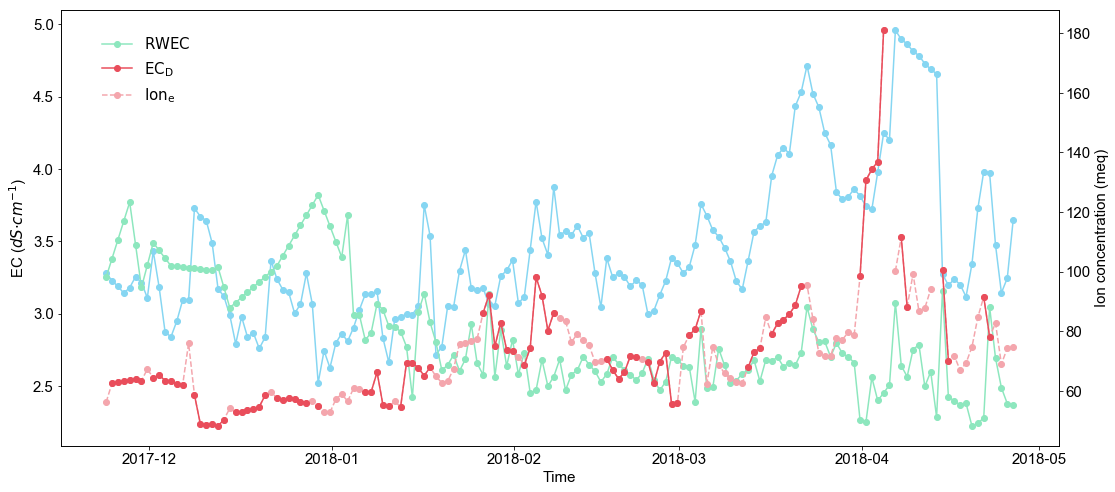

In [33]:
# x_date = interpol_result.index

fig , ec = plt.subplots(figsize=((8/2.54)*5, (6/2.54)*3))
linear_ecd, = ec.plot(x_date, env_6h.loc[all_meq_ground.index, "ECD(4)"], "-o", c=cmap_m[4], label = "EC")
linear_ecs, = ec.plot(x_date, env_6h.loc[all_meq_ground.index, "RWEC(4)"], "-o", c=cmap_m[3], label = "EC")
ec.set_xlabel("Time"),
ec.set_ylabel("EC ($\it{dS{\cdot}cm^{-1}}$)")
#ec.set_ybound([2,4])

ion = ec.twinx()
linear_m, = ion.plot(x_date, all_meq_ground.iloc[:, 0], "o--", markersize = MARKER_SIZE*2, c=cmap_m[0], label = "Ion_m")
linear, = ion.plot(x_date, all_meq_interpol.iloc[:, 0], "o-", markersize = MARKER_SIZE*2, c=cmap[0], label = "Ion_p")
ion.set_ylabel("Ion concentration (meq)")

fig.legend(handles=[linear_ecs,linear,linear_m], labels = ["$RWEC$", "$EC_D$", "$Ion_e$", "$Ion_m$"], frameon=False, bbox_to_anchor=(0.18, 0.92))

#plt.axis([x_date[0] - 5, x_date[-1] + 5, min_ - 1, max_ + 15])
fig.tight_layout()
plt.show()